# Examining weather dependence
James Thomas\
19th August 2020

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons Licence CC BY-SA 4.0" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a>

For references, see _[Estimating average energy use by property type in England](average_energy_use_by_property_type.ipynb)_.

In [2]:
import geopandas
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
lsoas = geopandas.read_file(
    "../raw_data/shapefiles/Lower_Layer_Super_Output_Areas__December_2011__Boundaries_EW_BSC_v2.shp",
).set_index("LSOA11CD")
lsoas.head()

,OBJECTID,LSOA11NM,LSOA11NMW,Shape__Are,Shape__Len,Region,geometry
LSOA11CD,,,,,,,
E01013150,1,North East Lincolnshire 013B,North East Lincolnshire 013B,2.842166e+05,2286.649368,11,"POLYGON ((523566.220 408258.530, 523096.506 40..."
E01015580,2,Swindon 007D,Swindon 007D,4.534211e+05,3426.828755,5,"POLYGON ((414944.595 186429.258, 414835.839 18..."
E01023601,3,North Hertfordshire 010A,North Hertfordshire 010A,2.801437e+05,2228.370570,1,"POLYGON ((518700.406 229239.907, 518624.973 22..."
E01024217,4,Dover 005B,Dover 005B,7.351294e+06,13012.376562,2,"POLYGON ((637601.843 154337.077, 636963.564 15..."
E01000722,5,Bromley 023A,Bromley 023A,5.691620e+05,3524.308527,1,"POLYGON ((547217.210 168066.578, 547226.999 16..."


In [8]:
gas = pd.read_csv("../raw_data/gas/LSOA_GAS_2018.csv", index_col="LSOACode").iloc[:-1]["MEDIAN"]
combined = lsoas.assign(
    gas=lsoas.index.map(gas)
)
combined.head()

,OBJECTID,LSOA11NM,LSOA11NMW,Shape__Are,Shape__Len,Region,geometry,gas
LSOA11CD,,,,,,,,
E01013150,1,North East Lincolnshire 013B,North East Lincolnshire 013B,2.842166e+05,2286.649368,11,"POLYGON ((523566.220 408258.530, 523096.506 40...",11964.705880
E01015580,2,Swindon 007D,Swindon 007D,4.534211e+05,3426.828755,5,"POLYGON ((414944.595 186429.258, 414835.839 18...",11843.409320
E01023601,3,North Hertfordshire 010A,North Hertfordshire 010A,2.801437e+05,2228.370570,1,"POLYGON ((518700.406 229239.907, 518624.973 22...",9504.950495
E01024217,4,Dover 005B,Dover 005B,7.351294e+06,13012.376562,2,"POLYGON ((637601.843 154337.077, 636963.564 15...",7836.291913
E01000722,5,Bromley 023A,Bromley 023A,5.691620e+05,3524.308527,1,"POLYGON ((547217.210 168066.578, 547226.999 16...",12249.506900


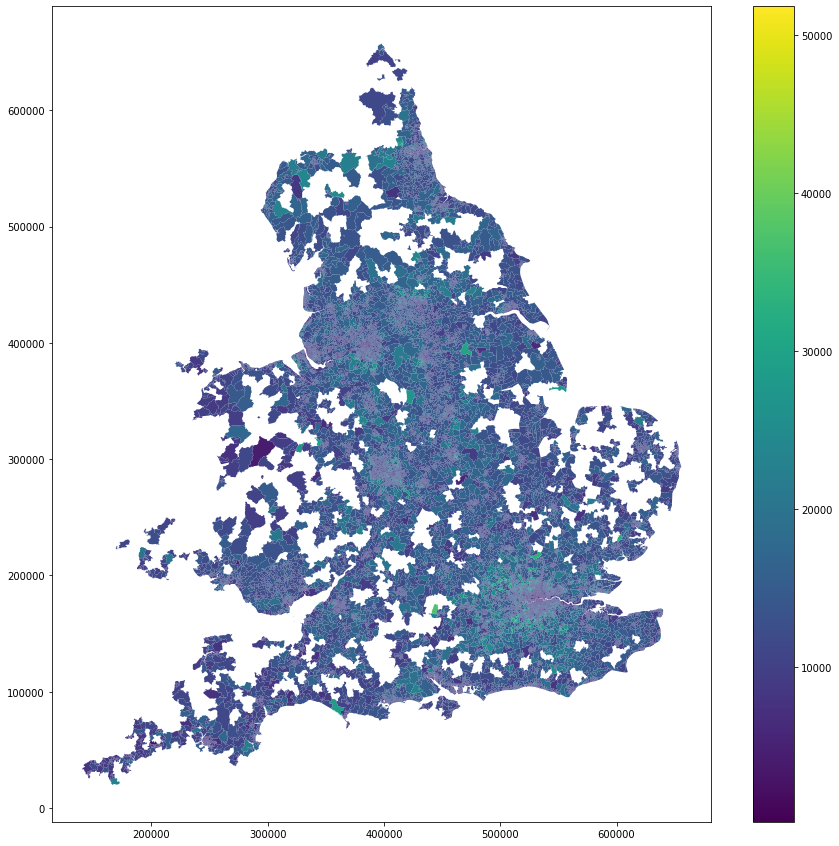

In [9]:
ax = combined.plot("gas", legend=True, figsize=(15, 15))
cmap = ax.collections[0].cmap
vmin, vmax = ax.collections[0].get_clim()

(119485.88004148273, 814436.1291518196, -8835.178933086809, 686115.0701772501)

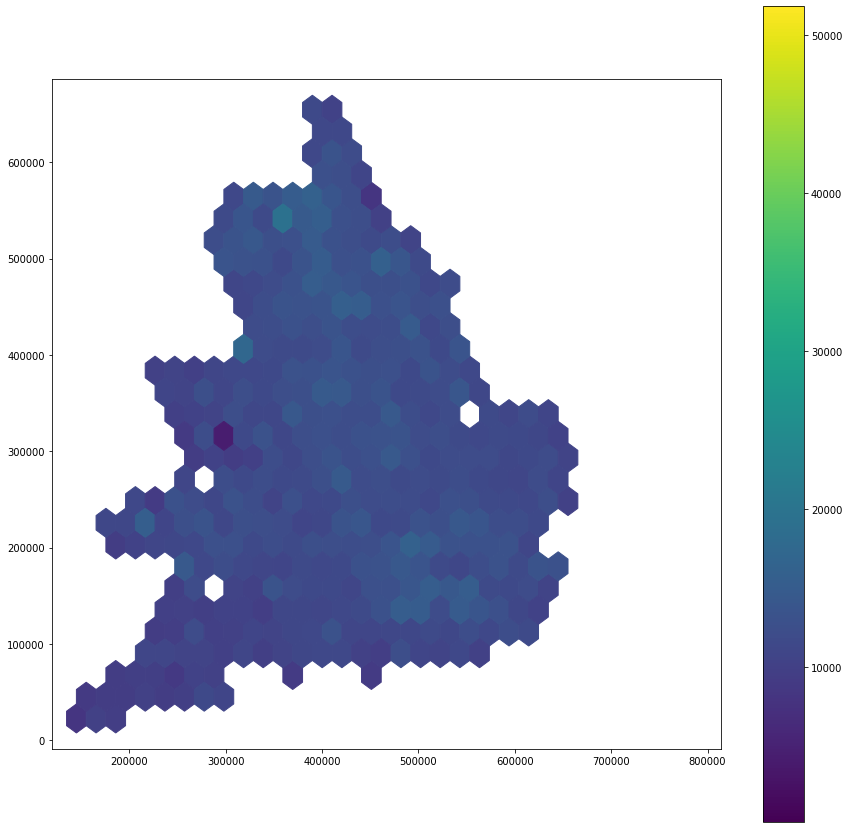

In [10]:
centroids = combined.geometry.centroid
plt.figure(figsize=(15, 15))
plt.hexbin(centroids.x, centroids.y, combined["gas"], cmap=cmap, vmin=vmin, vmax=vmax, gridsize=25)
plt.colorbar()
plt.axis("square")

In [11]:
ddh = pd.read_excel(
    "../raw_data/ddh/uk_20year.xls",
    skiprows=5,
    header=None,
    names=["Month", "Region", "HDD18.5", "HDD15.5", "HDD5.0", "CDD15.5", "CDD5.0", "CDD-20"],
).set_index(["Month", "Region"])
ddh = ddh.loc["Year"]["HDD15.5"]
ddh.index = ddh.index.str[:2].astype(int)
ddh.head(3)

Region
1    1771.6125
2    2035.7200
3    1942.8200
Name: HDD15.5, dtype: float64

In [13]:
regions = pd.read_csv("../map_data/lsoa_region_lookup.csv", index_col="LSOA11CD", usecols=["LSOA11CD", "Region"], squeeze=True)
regions = regions.dropna().astype(int)
regions = regions[regions.index.dropna()]
regions.head()

LSOA11CD
E01013150    11
E01015580     5
E01023601     1
E01024217     2
E01000722     1
Name: Region, dtype: int64

In [14]:
lsoa_to_ddh = regions.map(ddh).dropna().rename("DDH_region")

In [15]:
lsoa_ddhs = lsoas[["geometry"]].assign(ddh=lsoas.index.map(lsoa_to_ddh))
lsoa_ddhs.head()

,geometry,ddh
LSOA11CD,,
E01013150,"POLYGON ((523566.220 408258.530, 523096.506 40...",2112.7250
E01015580,"POLYGON ((414944.595 186429.258, 414835.839 18...",1890.8850
E01023601,"POLYGON ((518700.406 229239.907, 518624.973 22...",1771.6125
E01024217,"POLYGON ((637601.843 154337.077, 636963.564 15...",2035.7200
E01000722,"POLYGON ((547217.210 168066.578, 547226.999 16...",1771.6125


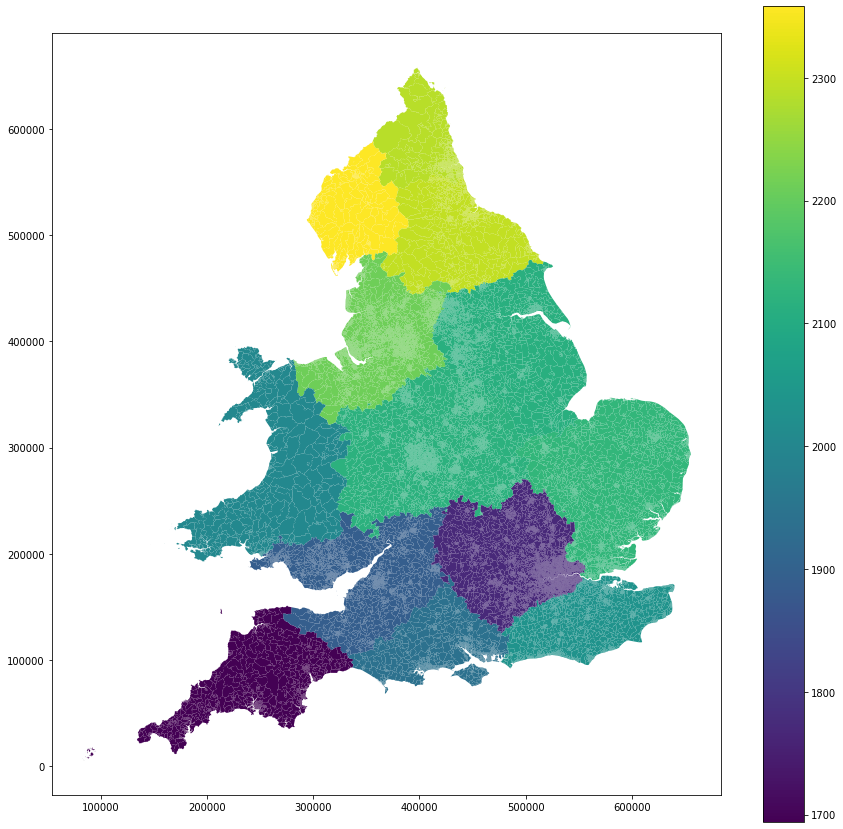

In [16]:
ax = lsoa_ddhs.plot("ddh", legend=True, figsize=(15, 15))
cmap = ax.collections[0].cmap
vmin, vmax = ax.collections[0].get_clim()

(62277.9668383504, 768165.2452592981, -19275.0705477608, 686612.2078731869)

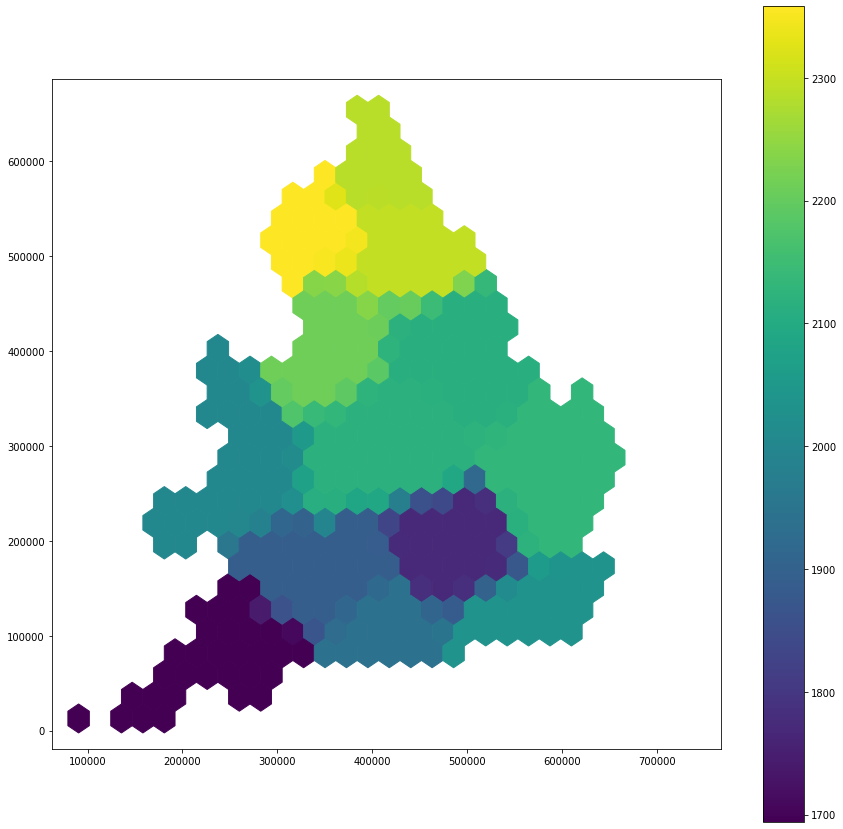

In [17]:
centroids = lsoa_ddhs.geometry.centroid
plt.figure(figsize=(15, 15))
plt.hexbin(centroids.x, centroids.y, lsoa_ddhs["ddh"], cmap=cmap, vmin=vmin, vmax=vmax, gridsize=25)
plt.colorbar()
plt.axis("square")